<a href="https://colab.research.google.com/github/vas59/audio_python/blob/master/audio_research_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


In [5]:
from imutils import paths
from keras.preprocessing.image import img_to_array
import random

Using TensorFlow backend.


In [2]:
!rm -rf audio_dataset
!git clone https://github.com/vas59/audio_dataset.git

Cloning into 'audio_dataset'...
remote: Enumerating objects: 65009, done.
remote: Total 65009 (delta 0), reused 0 (delta 0), pack-reused 65009
Receiving objects: 100% (65009/65009), 525.78 MiB | 23.93 MiB/s, done.
Resolving deltas: 100% (199/199), done.
Checking out files: 100% (64986/64986), done.


In [0]:
imagePaths = sorted(list(paths.list_images("audio_dataset/images_out")))


In [0]:
random.seed(42)
random.shuffle(imagePaths)

In [0]:
data = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath, 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))/255.0
    data.append(image)

data = np.array(data)

In [0]:

# for i in data:
q = np.array([w.mean() for w in data]  )

In [10]:
q

array([0.11285424, 0.12516468, 0.06752164, ..., 0.12528244, 0.16223863,
       0.00860811])

In [0]:
import os
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
labels = np.array(labels)

In [17]:
labels2 = labels[q > 0.0015]
data2 = data[q > 0.0015]
data2.shape

(50735, 64, 64)

In [0]:
data = data2
labels = labels2

In [19]:
q.shape

(50818,)

In [0]:
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Input, Dense, Reshape
from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras import Model

In [22]:
#auto decoder
input_ = Input((64, 64, 1)) 

x = Conv2D(filters=4, kernel_size=2, strides=2, activation='relu',padding='same')(input_) 
x = Conv2D(filters=6, kernel_size=2, strides=2, activation='relu',padding='same')(x)
x = Conv2D(filters=8,kernel_size=2, strides=2, activation='relu',padding='same')(x) 
flat = Flatten()(x)
latent = Dense(128,activation='relu')(flat)


reshape = Reshape((-1,8,8)) 
dense = Dense(512,activation='relu')
conv_2t_1 = Conv2DTranspose(filters=8, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_2 = Conv2DTranspose(filters=6, kernel_size=2, strides=2, activation='relu',padding='same') 
conv_2t_3 = Conv2DTranspose(filters=1, kernel_size=2, strides=2, activation='relu',padding='same') 
 

x = dense(latent)
x = reshape(x)
x = conv_2t_1(x)
x = conv_2t_2(x)
decoded = conv_2t_3(x) 

autoencoder = Model(input_, decoded)
encoder = Model(input_, latent)

decoder_input = Input((128,))
x_ = dense(decoder_input)
x_ = reshape(x_)
x_ = conv_2t_1(x_)
x_ = conv_2t_2(x_)
decoded_ = conv_2t_3(x_) 
decoder = Model(decoder_input, decoded_)

W0725 17:49:15.582165 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 17:49:15.625203 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 17:49:15.641515 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [23]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         20        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 6)         102       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           200       
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
__________

In [24]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


W0725 17:49:19.334645 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 17:49:19.362660 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0725 17:49:19.369862 139691602151296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
data = np.expand_dims(data, -1)

In [26]:
data.shape

(50735, 64, 64, 1)

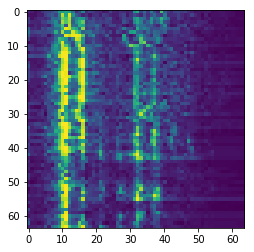

In [27]:
plt.imshow(np.squeeze(data[30]))

In [28]:
autoencoder.fit(x = data, y = data, batch_size=128, epochs=37) #10+27

W0725 17:49:50.639124 139691602151296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/37
50735/50735 [==============================] - 13s 261us/step - loss: 0.3133
Epoch 2/37
50735/50735 [==============================] - 8s 157us/step - loss: 0.2543
Epoch 3/37
50735/50735 [==============================] - 8s 160us/step - loss: 0.2506
Epoch 4/37
50735/50735 [==============================] - 7s 137us/step - loss: 0.2518
Epoch 5/37
50735/50735 [==============================] - 8s 160us/step - loss: 0.2486
Epoch 6/37
50735/50735 [==============================] - 8s 155us/step - loss: 0.2492
Epoch 7/37
50735/50735 [==============================] - 8s 155us/step - loss: 0.2477
Epoch 8/37
50735/50735 [==============================] - 8s 157us/step - loss: 0.2472
Epoch 9/37
50735/50735 [==============================] - 8s 154us/step - loss: 0.2469
Epoch 10/37
50735/50735 [==============================] - 8s 154us/step - loss: 0.2467
Epoch 11/37
50735/50735 [==============================] - 8s 155us/step - loss: 0.2466
Epoch 12/37
50735/50735 [===============

In [0]:
pred = encoder.predict(np.expand_dims(data[6000],axis=0))


In [0]:
pred_x = encoder.predict(data)

In [0]:
encoder.save("encoder_model_12000_out.h5")
# encoder.save_weights("encoder.h5")

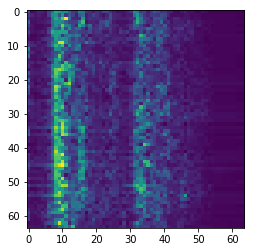

In [30]:
plt.imshow(np.squeeze(data[6000]))

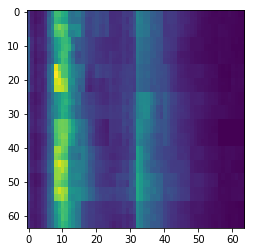

In [31]:
plt.imshow(np.squeeze(decoder.predict(pred)[0]))

In [35]:
pred_x[6001]

array([0.948084  , 0.7643084 , 2.9084885 , 1.5617592 , 2.4436653 ,
       0.        , 1.2172883 , 0.3524298 , 0.        , 0.        ,
       0.        , 0.        , 0.55534184, 0.        , 0.21258853,
       0.8996606 , 0.80584574, 0.63419324, 0.33756402, 1.0516057 ,
       1.1113516 , 0.        , 0.66860074, 0.        , 1.4708054 ,
       0.96437925, 0.7823256 , 2.575723  , 0.        , 0.4740736 ,
       2.3675206 , 1.097592  , 0.        , 1.2585616 , 1.8208413 ,
       0.        , 0.9885653 , 0.        , 2.625671  , 0.9975333 ,
       0.        , 1.8988785 , 0.        , 2.7696483 , 0.        ,
       0.9041214 , 1.1636318 , 0.        , 1.2785805 , 0.        ,
       0.        , 0.        , 0.9394092 , 0.        , 1.5041827 ,
       1.6577635 , 1.7890118 , 1.4493033 , 1.306209  , 1.4393302 ,
       2.8637042 , 0.61945546, 0.76607865, 0.8090451 , 0.        ,
       2.3634331 , 1.031156  , 0.9471288 , 0.76237726, 1.2261571 ,
       0.47438103, 0.31602415, 3.0512917 , 1.0340284 , 0.     

In [36]:
!pip install catboost

In [0]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

In [0]:
reset_keras()

In [0]:
import catboost

In [0]:
clf = catboost.CatBoostClassifier(task_type='GPU')

In [46]:
clf.fit(pred_x, np.array(labels))

0:	learn: 1.3467495	total: 31.4ms	remaining: 31.3s
1:	learn: 1.3101380	total: 48.9ms	remaining: 24.4s
2:	learn: 1.2768070	total: 66.3ms	remaining: 22s
3:	learn: 1.2451918	total: 83.3ms	remaining: 20.7s
4:	learn: 1.2166699	total: 100ms	remaining: 20s
5:	learn: 1.1902479	total: 117ms	remaining: 19.5s
6:	learn: 1.1648508	total: 135ms	remaining: 19.1s
7:	learn: 1.1405087	total: 153ms	remaining: 18.9s
8:	learn: 1.1180514	total: 169ms	remaining: 18.6s
9:	learn: 1.0956039	total: 187ms	remaining: 18.5s
10:	learn: 1.0750198	total: 204ms	remaining: 18.4s
11:	learn: 1.0558576	total: 222ms	remaining: 18.2s
12:	learn: 1.0371045	total: 243ms	remaining: 18.5s
13:	learn: 1.0186292	total: 256ms	remaining: 18.1s
14:	learn: 1.0023985	total: 269ms	remaining: 17.7s
15:	learn: 0.9856947	total: 282ms	remaining: 17.3s
16:	learn: 0.9701586	total: 295ms	remaining: 17s
17:	learn: 0.9545210	total: 307ms	remaining: 16.8s
18:	learn: 0.9396197	total: 321ms	remaining: 16.5s
19:	learn: 0.9256726	total: 333ms	remaining

In [64]:
clf.predict(pred_x[10030])

array([['The_Show_Must_Go_On']], dtype='<U19')

In [65]:
clf.predict_proba(pred_x[10030])# The_Show_Must_Go_On We_Are_The_Champions We_Will_Rock_You none

array([[9.74653131e-01, 1.46841619e-02, 1.06369882e-02, 2.57186939e-05]])

In [48]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, clf.predict(pred_x)))

0.9978712920074899


In [0]:
clf.save_model("catboost_decoder_12000_1.catboost")